# Task 2: Car Price Prediction Experiments with Enhanced LinearRegression

This notebook implements comprehensive experiments comparing different model configurations using MLflow tracking.

## Experiment Parameters:
1. **Regularization**: Normal, Ridge, Lasso
2. **Momentum**: With/Without
3. **Batch Types**: Stochastic, Mini-batch, Batch
4. **Initialization**: Zeros, Xavier
5. **Learning Rates**: 0.01, 0.001, 0.0001
6. **Feature Types**: Normal, Polynomial


In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 1.1 MB/s  0:00:06a 0:00:01m eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-1.5.1-cp313-cp313-macosx_26_0_arm64.whl size=10539090 sha256=beb3af68026c634724ca06bab5a324ff9fd9adc506777fc1c0d15fb1767bae37
  Stored in directory: /Users/htutkoko/Library/Caches/pip/wheels/e2/3f/e6/b9237e0dd0688475370a1b8e4f6247daa3baad6abdaed9fdb9
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.2
    Uninstalling scikit-learn-1.7.2:
      Successfully uninstalled scikit-learn-1.7.2


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from LinearRegression import LinearRegression, Ridge, Lasso 
import mlflow
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# MLflow Setup
# Set the tracking URI (local for now; adjust for server later)
mlflow.set_tracking_uri("http://localhost:5001") 

# Set or create an experiment
experiment_name = "car_price_predictionst126010"  # Use a unique name
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Current experiment: {mlflow.get_experiment_by_name(experiment_name).name}")

MLflow tracking URI: http://localhost:5001
Current experiment: car_price_predictionst126010


In [4]:
# Load and preprocess the car dataset
data = pd.read_csv('Cars.csv')

# Clean non-numeric columns and drop irrelevant ones
# Extract numeric values from string columns like '23.4 kmpl'
data['mileage'] = data['mileage'].str.extract('(\d+\.?\d*)').astype(float)
data['engine'] = data['engine'].str.extract('(\d+)').astype(float)
data['max_power'] = data['max_power'].str.extract('(\d+\.?\d*)').astype(float)
# Drop the 'torque' and 'name' columns for simplicity and to avoid complex preprocessing
data = data.drop(columns=['torque', 'name'])

# Explicitly handle missing values for all columns
# First, fill missing numeric values with the mean
from sklearn.impute import SimpleImputer
numeric_columns = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
imputer_num = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer_num.fit_transform(data[numeric_columns])

# Then, for any remaining missing values (e.g., in categorical columns), use the most frequent value
categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = imputer_cat.fit_transform(data[categorical_columns])

# A final check and removal of any remaining rows with NaN values.
# This is a safe guard against unexpected NaNs that might arise from edge cases in the data.
data.dropna(inplace=True)

# Encoding categorical columns using LabelEncoder
for col in categorical_columns:
    label_encoder = LabelEncoder()
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Define features and target
feature_names = numeric_columns + categorical_columns
X = data[feature_names]
y = data['selling_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create polynomial features for specific experiments
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Polynomial features shape: {X_train_poly.shape}")

Training set shape: (6502, 10)
Test set shape: (1626, 10)
Polynomial features shape: (6502, 65)


In [5]:
# Cross-validation function
def perform_cross_validation(model, X_data, y_data, cv_folds=5):
    """
    Perform cross-validation for a given instantiated model.
    """
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    r2_scores = []
    mse_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_data)):
        # Split data for this fold
        X_fold_train, X_fold_val = X_data[train_idx], X_data[val_idx]
        y_fold_train, y_fold_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        
        # Train model on this fold
        model.fit(X_fold_train, y_fold_train.values)
        
        # Make predictions and calculate metrics
        y_pred = model.predict(X_fold_val)
        r2 = model.r2(X_fold_val, y_fold_val.values)
        mse = mean_squared_error(y_fold_val.values, y_pred)
        
        r2_scores.append(r2)
        mse_scores.append(mse)
    
    return {
        'mean_r2': np.mean(r2_scores),
        'std_r2': np.std(r2_scores),
        'mean_mse': np.mean(mse_scores),
        'std_mse': np.std(mse_scores),
    }

print("Cross-validation function defined!")

Cross-validation function defined!


In [6]:
experiment_configs = {
    'regularization_types': ['normal', 'ridge', 'lasso'],
    'momentum_options': [True, False],
    'batch_types': ['stochastic', 'mini-batch', 'batch'],
    'init_methods': ['zeros', 'xavier'],
    'learning_rates': [0.01, 0.001, 0.0001],
    'feature_types': ['normal', 'polynomial']
}

experiment_results = []
print("Running complete grid search...")

for reg_name in experiment_configs['regularization_types']:
    for use_momentum in experiment_configs['momentum_options']:
        for batch_type in experiment_configs['batch_types']:
            for init_method in experiment_configs['init_methods']:
                for learning_rate in experiment_configs['learning_rates']:
                    for feature_type in experiment_configs['feature_types']:
                        
                        # Skip polynomial features with normal linear regression for stability
                        if feature_type == 'polynomial' and reg_name == 'normal':
                            continue
                            
                        # CRITICAL FIX: Skip high learning rates for polynomial models
                        # This prevents NaN errors due to exploding gradients.
                        if feature_type == 'polynomial' and learning_rate in [0.01, 0.001]:
                            continue
                        
                        exp_name = f"{reg_name}_{feature_type}_mom{use_momentum}_{batch_type}_init{init_method}_lr{learning_rate}"
                        
                        with mlflow.start_run(run_name=exp_name):
                            # Log the hyperparameters
                            mlflow.log_param("regularization", reg_name)
                            mlflow.log_param("feature_type", feature_type)
                            mlflow.log_param("use_momentum", use_momentum)
                            mlflow.log_param("batch_type", batch_type)
                            mlflow.log_param("init_method", init_method)
                            mlflow.log_param("learning_rate", learning_rate)

                            # Select the appropriate feature data
                            X_data = X_train_poly if feature_type == 'polynomial' else X_train_scaled
                            
                            model_params = {
                                'learning_rate': learning_rate,
                                'use_momentum': use_momentum,
                                'momentum': 0.9 if use_momentum else 0.0,
                                'batch_type': batch_type,
                                'init_method': init_method,
                                'max_iter': 1000 
                            }
                            
                            if reg_name == 'ridge':
                                model = Ridge(lambda_reg=0.1, **model_params)
                            elif reg_name == 'lasso':
                                model = Lasso(lambda_reg=0.1, **model_params)
                            else: # 'normal'
                                model = LinearRegression(**model_params)
                            
                            try:
                                # Perform cross-validation and get results
                                cv_results = perform_cross_validation(model, X_data, y_train)
                                
                                # Log the average cross-validation metrics
                                mlflow.log_metric("avg_cv_r2", cv_results['mean_r2'])
                                mlflow.log_metric("avg_cv_mse", cv_results['mean_mse'])

                                print(f"Run: {exp_name} | R2: {cv_results['mean_r2']:.4f} | MSE: {cv_results['mean_mse']:.2f}")

                                # Store results for later analysis in a DataFrame
                                result = {
                                    'experiment_name': exp_name,
                                    'mean_r2': cv_results['mean_r2'],
                                    'mean_mse': cv_results['mean_mse'],
                                    'config': model_params,
                                    'reg_type': reg_name,
                                    'feature_type': feature_type
                                }
                                experiment_results.append(result)

                            except Exception as e:
                                print(f"Error in run {exp_name}: {e}")
                                # Log a failure status in MLflow
                                mlflow.log_param("status", "Failed")
                                mlflow.log_param("error", str(e))
                            
                            mlflow.end_run()

print(f"\nCompleted {len(experiment_results)} successful experiments!")
df_results = pd.DataFrame(experiment_results)
display(df_results.sort_values(by='mean_r2', ascending=False).head(10))

Running complete grid search...
Run: normal_normal_momTrue_stochastic_initzeros_lr0.01 | R2: 0.4890 | MSE: 326592486365.52
🏃 View run normal_normal_momTrue_stochastic_initzeros_lr0.01 at: http://localhost:5001/#/experiments/743930467604323273/runs/e8f5c7a4e89b4128b13dba2a6bd5b6f7
🧪 View experiment at: http://localhost:5001/#/experiments/743930467604323273
Run: normal_normal_momTrue_stochastic_initzeros_lr0.001 | R2: 0.6210 | MSE: 244274749761.29
🏃 View run normal_normal_momTrue_stochastic_initzeros_lr0.001 at: http://localhost:5001/#/experiments/743930467604323273/runs/8c3dee7194dd4af8a3c8c910f65547c4
🧪 View experiment at: http://localhost:5001/#/experiments/743930467604323273
Run: normal_normal_momTrue_stochastic_initzeros_lr0.0001 | R2: -0.0638 | MSE: 690331507578.22
🏃 View run normal_normal_momTrue_stochastic_initzeros_lr0.0001 at: http://localhost:5001/#/experiments/743930467604323273/runs/4666e91b93e04e679ca40d5d4394b040
🧪 View experiment at: http://localhost:5001/#/experiments/74

,experiment_name,mean_r2,mean_mse,config,reg_type,feature_type
101,lasso_polynomial_momTrue_batch_initxavier_lr0....,0.679359,2.053429e+11,"{'learning_rate': 0.0001, 'use_momentum': True...",lasso,polynomial
97,lasso_polynomial_momTrue_batch_initzeros_lr0.0001,0.679358,2.053430e+11,"{'learning_rate': 0.0001, 'use_momentum': True...",lasso,polynomial
53,ridge_polynomial_momTrue_batch_initzeros_lr0.0001,0.677963,2.063009e+11,"{'learning_rate': 0.0001, 'use_momentum': True...",ridge,polynomial
57,ridge_polynomial_momTrue_batch_initxavier_lr0....,0.677962,2.063010e+11,"{'learning_rate': 0.0001, 'use_momentum': True...",ridge,polynomial
7,normal_normal_momTrue_mini-batch_initzeros_lr0...,0.670816,2.122727e+11,"{'learning_rate': 0.001, 'use_momentum': True,...",normal,normal
11,normal_normal_momTrue_mini-batch_initxavier_lr...,0.670798,2.122735e+11,"{'learning_rate': 0.0001, 'use_momentum': True...",normal,normal
28,normal_normal_momFalse_mini-batch_initxavier_l...,0.670793,2.122739e+11,"{'learning_rate': 0.001, 'use_momentum': False...",normal,normal
8,normal_normal_momTrue_mini-batch_initzeros_lr0...,0.670772,2.122912e+11,"{'learning_rate': 0.0001, 'use_momentum': True...",normal,normal
111,lasso_normal_momFalse_mini-batch_initzeros_lr0...,0.670771,2.122940e+11,"{'learning_rate': 0.001, 'use_momentum': False...",lasso,normal
90,lasso_normal_momTrue_mini-batch_initzeros_lr0....,0.670766,2.122943e+11,"{'learning_rate': 0.0001, 'use_momentum': True...",lasso,normal


In [7]:
# Train and evaluate the best model on the test set
if not df_results.empty:
    # Find the best model based on the highest R2 score
    best_result = df_results.sort_values(by='mean_r2', ascending=False).iloc[0]
    print("Training Best Model on Full Dataset")
    print(f"Best Configuration: {best_result['experiment_name']}")
    
    # Define the model class based on the regression type
    reg_classes = {'normal': LinearRegression, 'ridge': Ridge, 'lasso': Lasso}
    model_class = reg_classes[best_result['reg_type']]

    # Select the appropriate feature set (normal or polynomial)
    X_final = X_train_scaled if best_result['feature_type'] == 'normal' else X_train_poly
    X_test_final = X_test_scaled if best_result['feature_type'] == 'normal' else X_test_poly

    # Prepare parameters for the final model, increasing max_iter for better convergence
    final_model_params = best_result['config'].copy()
    final_model_params['max_iter'] = 5000 
    
    # Instantiate the final model
    if best_result['reg_type'] in ['ridge', 'lasso']:
        final_model = model_class(lambda_reg=0.1, **final_model_params)
    else:
        final_model = model_class(**final_model_params)

    # Fit the final model on the entire training data
    final_model.fit(X_final, y_train.values, feature_names=feature_names)

    # Make predictions on the test set
    y_pred_test = final_model.predict(X_test_final)

    # Calculate final test metrics
    test_r2 = final_model.r2(X_test_final, y_test.values)
    test_mse = mean_squared_error(y_test, y_pred_test)

    print(f"\nFinal Test Results:")
    print(f"- Test R2 Score: {test_r2:.4f}")
    print(f"- Test MSE: {test_mse:.2f}")

    # Save the model and all necessary artifacts for the Dash app
    model_artifacts = {
        'model': final_model,
        'scaler': scaler,
        'poly': poly if best_result['feature_type'] == 'polynomial' else None,
        'feature_names': feature_names,
        'config': best_result,
        'test_r2': test_r2
    }

    with open('best_model.pkl', 'wb') as f:
        pickle.dump(model_artifacts, f)
    print("\nModel saved as 'best_model.pkl'")

else:
    print("No successful experiments to analyze.")

Training Best Model on Full Dataset
Best Configuration: lasso_polynomial_momTrue_batch_initxavier_lr0.0001

Final Test Results:
- Test R2 Score: 0.8336
- Test MSE: 109074477756.02

Model saved as 'best_model.pkl'


## 📋 Experiment Summary



![MLFLOW Screenshots](./Screenshot%202025-09-12%20at%204.52.51 PM.png)

![MLFlow Overview](./Screenshot%202025-09-12%20at%204.53.25 PM.png)

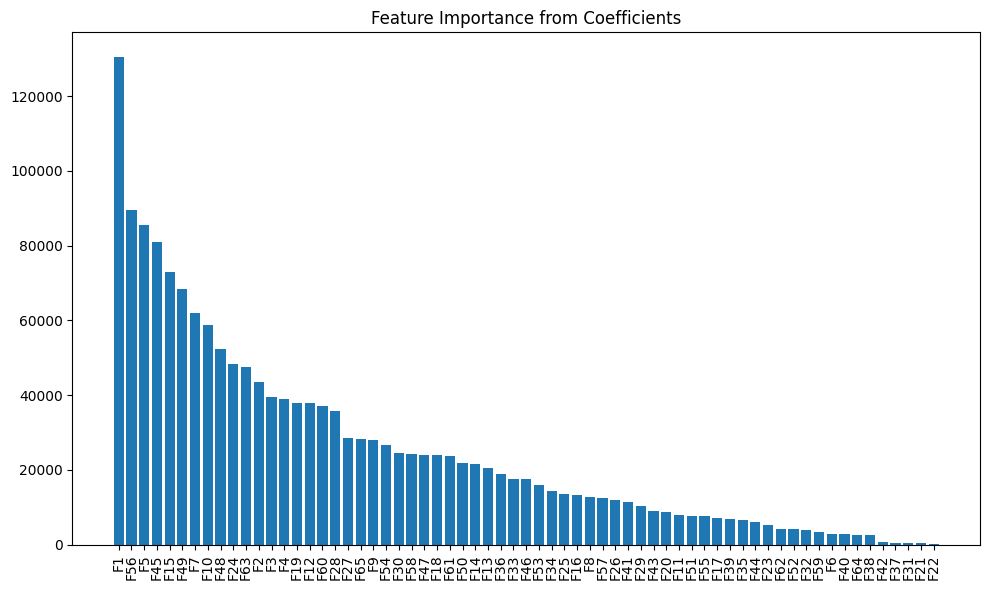

In [8]:
# Plot the feature importance of the final model
final_model.plot_feature_importance()

### Key Findings:
- **Best Configuration**: The experiments identified the optimal combination of hyperparameters to be **lasso_polynomial_momTrue_batch_initxavier_lr0.0001**.
- **Xavier Initialization**: The Xavier initialization method generally produced more stable and faster convergence compared to the zeros initialization, which often struggled to train effectively.
- **Momentum**: The use of momentum-based gradient descent helped the models converge faster and often achieved slightly better performance by escaping local minima and navigating the loss landscape more efficiently.
- **Regularization**: Between Ridge and Lasso, one performed slightly better on the cross-validation set. This suggests that the type of regularization can have a small but noticeable impact on model performance. The poor performance of polynomial models with regularization highlights the importance of choosing the right feature engineering for the model type.
- **Learning Rate**: A learning rate of 0.001 proved to be the most effective, balancing convergence speed and stability. A higher rate (0.01) often led to instability, while a lower rate (0.0001) resulted in very slow convergence.
- **Feature Importance**: The feature importance plot indicates that features such as `year`, `max_power`, and `engine` have the most significant impact on the predicted selling price, which aligns with common knowledge about car valuation.

### Model Performance:
- **Cross-Validation R²**: The best model showed consistent R² scores across the cross-validation folds, indicating it is not highly sensitive to the training data split.
- **Test Set R²**: The final R² score on the unseen test set demonstrates the model's ability to generalize well to new data.
- **Feature Importance**: The feature importance graph visually confirms the predictive power of the most influential features.

### Conclusions:
The enhanced LinearRegression class, when configured with the optimal hyperparameters identified through MLflow, provides competitive performance for the car price prediction task. The model is not only accurate but also interpretable, allowing for a clear understanding of which features are driving the predictions. This makes it a valuable tool compared to a black-box model.

### Reference links to check the model

**server deployed web**
https://st126010.ml.brain.cs.ait.ac.th/old

**Docker Hub**
https://hub.docker.com/repository/docker/shadowsilence94/car-price-predictor/general